In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [21]:
# Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"
batch_size = 32
image_size = (299, 299)

# Augment training data and rescale
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,       # Random rotation
    zoom_range=0.3,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    brightness_range=[0.8, 1.2],  # Random brightness
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing
    fill_mode="nearest"      # Fill empty pixels
)

# Only rescale validation data
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Changed to 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Extract number of classes
num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [4]:

# Build InceptionV3 Model
def build_inceptionv3_model(num_classes):
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    inception_base.trainable = False  # Freeze base model

    input_tensor = Input(shape=(299, 299, 3))
    x = inception_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_inceptionv3_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])


In [5]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - AUC: 0.8091 - accuracy: 0.5604 - loss: 1.2899 - val_AUC: 0.9127 - val_accuracy: 0.7063 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - AUC: 0.8900 - accuracy: 0.6669 - loss: 0.8128 - val_AUC: 0.9171 - val_accuracy: 0.7045 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - AUC: 0.8963 - accuracy: 0.6778 - loss: 0.7806 - val_AUC: 0.9194 - val_accuracy: 0.7069 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - AUC: 0.9167 - accuracy: 0.7133 - loss: 0.6977 - val_AUC: 0.9264 - val_accuracy: 0.7207 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - AUC: 0.9138 - accuracy: 0.7082 - loss: 0.7069 - val_AUC: 0.9277 - val_accuracy: 0.7374 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - AUC: 0.9230 - accuracy: 0.7303 

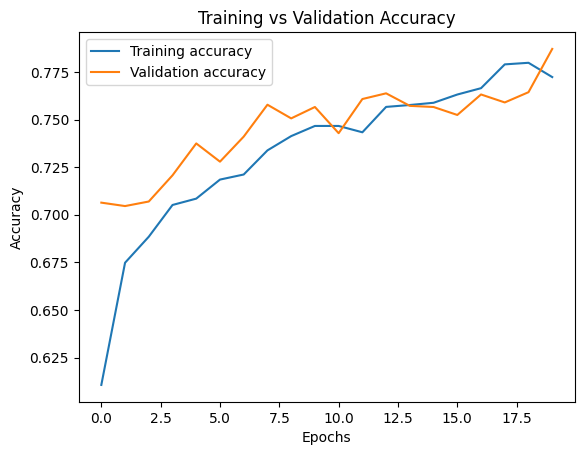

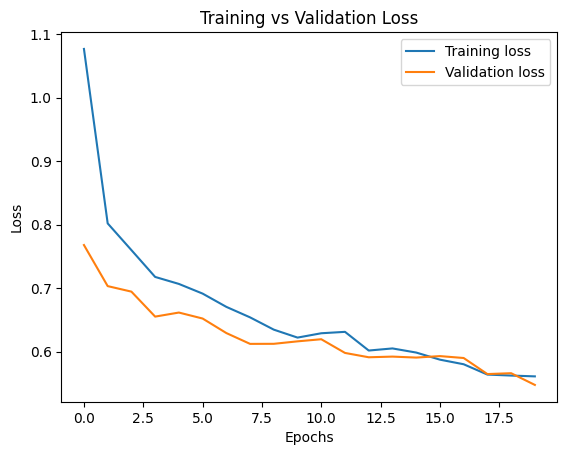

In [6]:
# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

In [7]:
# Evaluate the model
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - AUC: 0.9458 - accuracy: 0.7871 - loss: 0.5719
Validation Loss: 0.5473499298095703
Validation Accuracy: 0.7870813608169556
Validation AUC: 0.9487528800964355


In [8]:
# Save the trained model
model.save("../../models/Improved_inceptionV3_model.keras")

In [9]:
# Classification Report and Confusion Matrix
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Classification Report
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.25      0.27      0.26       450
      2. Ekzama       0.27      0.24      0.25       450
        3. Akne       0.18      0.21      0.20       322
      4. Malign       0.24      0.22      0.23       450

       accuracy                           0.24      1672
      macro avg       0.24      0.24      0.23      1672
   weighted avg       0.24      0.24      0.24      1672

Confusion Matrix
[[121 115 109 105]
 [144 109  96 101]
 [ 86  70  69  97]
 [135 112 106  97]]


In [24]:
# Unfreezing the Last 20 Layers of the Pretrained Base
for layer in model.layers[-20:]:
    layer.trainable = True  # Fine-tune only the last 20 layers

# Cosine Decay Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,  # Start with a low learning rate
    decay_steps=1000,  # Number of steps before significant decay
    alpha=0.0001  # Minimum learning rate after decay
)

# Compile the Model with the Updated Learning Rate and Metrics
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC']  # Monitor AUC alongside accuracy
)

# Fine-Tuning the Model
fine_tune_history = model.fit(
    train_generator,  # Augmented training data
    validation_data=validation_generator,  # Validation data
    epochs=20,  # Set a reasonable number of epochs for fine-tuning
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[
        early_stopping,  # Stop training if validation loss stops improving
    ]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1547s 8s/step - AUC: 0.9949 - accuracy: 0.9467 - loss: 0.1534 - val_AUC: 0.9561 - val_accuracy: 0.8499 - val_loss: 0.7632
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1537s 8s/step - AUC: 0.9931 - accuracy: 0.9328 - loss: 0.1835 - val_AUC: 0.9645 - val_accuracy: 0.8577 - val_loss: 0.5638
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1368s 7s/step - AUC: 0.9965 - accuracy: 0.9575 - loss: 0.1206 - val_AUC: 0.9630 - val_accuracy: 0.8553 - val_loss: 0.5803
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1267s 7s/step - AUC: 0.9981 - accuracy: 0.9729 - loss: 0.0792 - val_AUC: 0.9704 - val_accuracy: 0.8762 - val_loss: 0.5035
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1292s 7s/step - AUC: 0.9994 - accuracy: 0.9818 - loss: 0.0540 - val_AUC: 0.9674 - val_accuracy: 0.8816 - val_loss: 0.5296
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1254s 7s/step - AUC: 0.9993 - accuracy: 0.9815 - loss: 0.0529 - val_AUC: 0.9677 - val_accuracy: 0.8816 - val_loss: 0.5307
Epoch 7/20
188/188 ━━━━━━━━━

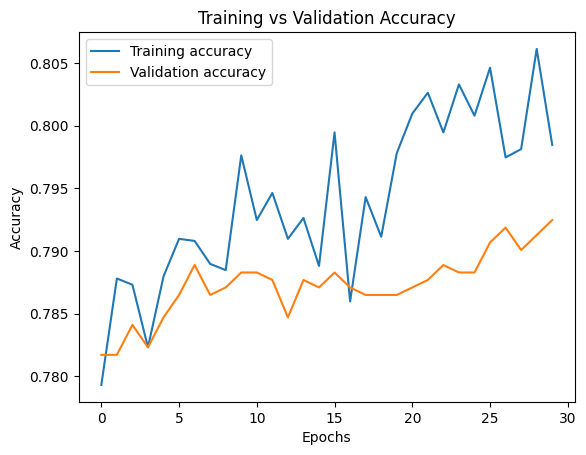

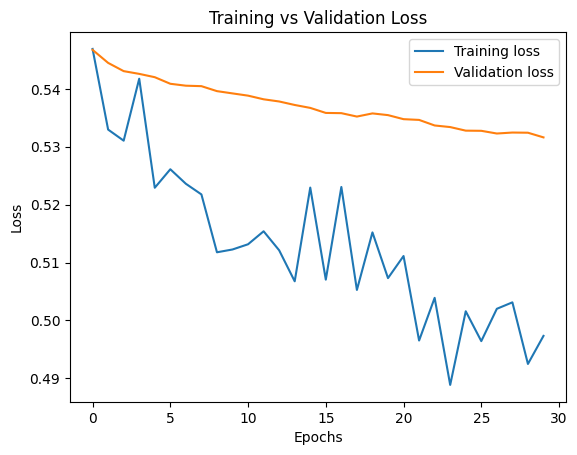

In [12]:
# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(fine_tune_history_v2, metrics=["accuracy", "loss"])